# 승촌보 데이터 분석 

* 승촌보 수질 데이터(Seungchonbo.xlsx)   
    * 2012-2022년  
    * 시간 단위 수집 데이터
* 승촌보 유량 데이터(Seungchonbo_flow.xlsx)
    * 2012-2022년
    * 10분 단위 수집 데이터

**필수 모듈 임포트**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from datetime import datetime

**훈련 모델 준비**

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

**matplotlib 한글 설정**

In [3]:
# 운영체제에 따른 한글 지원을 설정한다. 지원되는 환경은 윈도우, 우분투, 구글 코랩 등이다.

import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

## 승촌보 데이터 불러오기

### 수질 데이터 불러오기

**보 이름**

In [4]:
reservoir = 'Seungchonbo'

**데이터 저장소**

In [5]:
base_path = "https://github.com/codingalzi/water-data/raw/master/reservoirs/"
# base_path = r"C:\Users\owner\Desktop\water-source\data"

**시간 단위로 측정된 승촌보 연도별 수질 데이터 불러오기**

In [6]:
# '측정일/월' 특성은 date time으로 파싱.
# 반환값은 연도별 데이터프레임으로 구성된 사전. 2012년 ~ 2022년

data_file = reservoir+".xlsx"
scb_yearly = pd.read_excel(base_path+data_file, 
# scb_yearly = pd.read_excel(base_path+"\Seungchonbo.xlsx", 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 측정일/월 특성을 date time으로 파싱

**시간 특성을 "년-월-일 시" 형식으로 변환하는 함수**

In [7]:
# 연도별로 별도로 작동한다.

def time2datetime(df_yearly_dict, feature):
    for year in list(df_yearly_dict.keys()):
        df_yearly_dict[year][feature] = df_yearly_dict[year][feature].apply(lambda x : x.strftime('%Y-%m-%d %H'))
    
    return df_yearly_dict

`'측정일/월'` 특성을 '년-월-일 시'형식으로 변경한다.

In [8]:
scb_yearly = time2datetime(scb_yearly, '측정일/월')

**2012년도 데이터를 제외한 모든 데이터 통합 함수**

In [9]:
# 반환값은 데이터프레임

def concat_yearly_df(df_yearly_dict):
    df_concat = pd.DataFrame()

    for year in list(df_yearly_dict.keys())[1:]:
        df_concat = pd.concat([df_concat, df_yearly_dict[year]])

    return df_concat

**연도별 수질 데이터 통합**

In [10]:
# 2013년도부터 통합
scb_yearly_df13 = concat_yearly_df(scb_yearly)

# 인덱스 재설정
scb_yearly_df13 = scb_yearly_df13.reset_index(drop=True)

### 유량 데이터 불러오기

**10분 단위로 측정된 승촌보 연도별 유량 데이터 불러오기**

In [11]:
# `시간` 특성은 date time으로 파싱해서 불러온다.
# 반환값은 연도별 데이터프레임으로 구성된 사전. 2012년 ~ 2022년

flow_data_file = reservoir+"_flow.xlsx"
scb_flow_yearly = pd.read_excel(base_path+flow_data_file, 
# scb_flow_yearly = pd.read_excel(base_path+"\Seungchonbo_flow.xlsx", 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 시간 특성을 date time으로 파싱

`시간` 특성을 '년-월-일 시' 형식으로 변경한다. 

In [12]:
scb_flow_yearly = time2datetime(scb_flow_yearly, '시간')

**10분 단위를 1시간 단위로 변경**

시간별 평균값을 활용한다.

In [13]:
scb_flow_yearly_hour = {}

# groupby의 as_index=False 옵션 사용. 인덱스 자동 재설정됨.
for year in list(scb_flow_yearly.keys()):
    scb_flow_yearly_hour[year] = scb_flow_yearly[year].groupby('시간', as_index=False).mean()

**연도별 유량 데이터 통합**

In [14]:
# 2013년부터 통합
scb_flow_yearly_hour_df = concat_yearly_df(scb_flow_yearly_hour)

# 인덱스 재설정
scb_flow_yearly_hour_df = scb_flow_yearly_hour_df.reset_index(drop=True)

### 수질/유량 데이터 합병

수질 데이터와 유량 데이터를 `측정일/월`과 `시간` 기준으로 합병한다.

In [15]:
# 수질 데이터의 `측정일/월` 특성 이름을 `시간`으로 변경
scb_yearly_df13 = scb_yearly_df13.rename(columns={'측정일/월':'시간'})

# `pd.merge()`에서 `how = 'outer'` 키워드 인자 : 두 데이터에 사용된 모든 시간대의 데이터를 모두 추가한다(합집합).
scb_data = pd.merge(scb_yearly_df13, scb_flow_yearly_hour_df, how='outer')

# 유량 데이터 2022년도 데이터를 더 많이 포함하기에 삭제 필요.
scb_data = scb_data[:len(scb_yearly_df13)]

# 유량 특성 이름에 공백이 사용되었기에 특성명에 공백 제거
scb_data.columns = [x.strip() for x in list(scb_data.columns)]

## 데이터셋 전처리

**특성 선택**

모델 훈련에 사용하지 않을 특성들은 삭제한다.

In [16]:
to_be_removed = ['측정소명', '수소이온농도', '용존산소 mg/L', '하류수위(EL.m)', '유입량(㎥/s)']

scb_data.drop(to_be_removed, axis=1, inplace=True)

남은 특성은 다음과 같다.

In [17]:
list(scb_data.columns)

['시간',
 '수온 ℃',
 '전기전도도 μS/cm',
 '총유기탄소 mg/L',
 '총질소 mg/L',
 '총인 mg/L',
 '클로로필-a mg/㎥',
 '상류수위(EL.m)',
 '방류량(㎥/s)']

**클로로필-a 특성 정규화**

`'클로로필-a mg/㎥'` 특성을 회귀 모델의 타깃으로 사용할 예정이다.
그런데 클로로필 값이 왼편으로 치우친 형태이다.

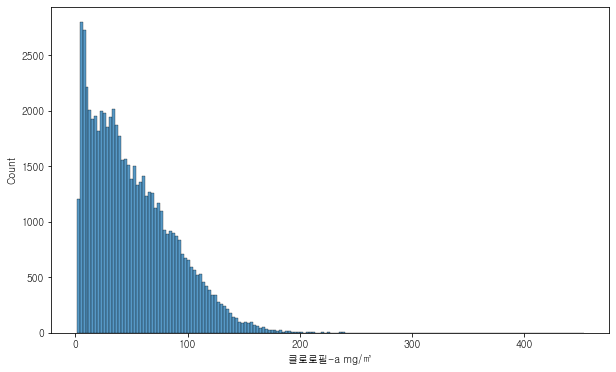

In [18]:
sns.histplot(scb_data['클로로필-a mg/㎥'])
plt.show()

`np.log1p()`를 사용해 로그변환하면 클로로필 값이 정규 분포에 가까워진다.

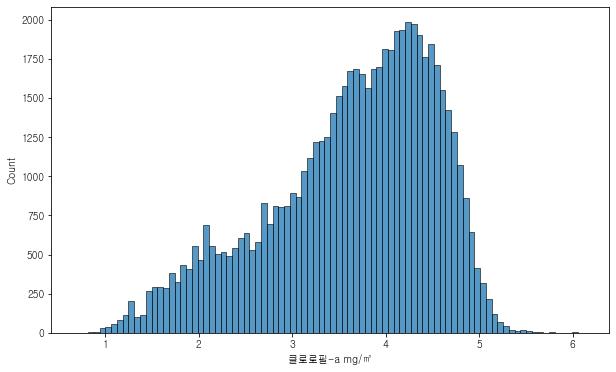

In [19]:
sns.histplot(np.log1p(scb_data['클로로필-a mg/㎥']))
plt.show()

클로로필 값을 로그 변환한 뒤 `scb_data`에 추가한 뒤 기존의 클로로필 특성은 고려하지 않는다.

In [20]:
scb_data['log_Chl-a'] = np.log1p(scb_data['클로로필-a mg/㎥'])

scb_data = scb_data.drop(['클로로필-a mg/㎥'], axis=1)

## shift 특성 추가 함수와 모델 훈련 함수

데이터셋을 복제해서 원본은 유지한다.

In [21]:
scb_df = scb_data.copy()

**shift 특성 추가 함수**

`feature_shifting()` 함수는 지정된 특성을 대상으로 지정된 크기만큼 shift한 특성을 추가한다. 함수의 인자로 다음 세 개의 값을 받는다.  

* `df` : 기존 데이터프레임
* `shift_feature` : shift 대상 특성
* `shift_step` : shift 크기
* 반환값: shift된 특성이 추가된 데이터프레임

In [22]:
from pandas import DataFrame
import re

def feature_shifting(df : DataFrame, shift_feature : str, shift_step : int) -> DataFrame:
    shift_feature_ = re.split(' |\(', shift_feature)[0] # 특성 이름에 사용된 단위 삭제. 공백 또는 여는 괄호 기준 쪼개기

    new_dict = dict()
    new_dict[str(shift_step) + 'shift_' + shift_feature_] = df[shift_feature].shift(shift_step)
    
    new_dict = pd.DataFrame(new_dict)

    return pd.concat([df, new_dict], axis=1)

**그리드 탐색 일괄 처리 함수**

`gridsearch()` 함수는 

* `model` : 그리드 탐색 대상 모델
* `parameters` : 그리드 탐색에 사용될 하이퍼파라미터 모음집
* `shift_objects` : shift 대상 특성 및 크기 모음 사전
* 반환값: shift 특성과 크기에 따른 최적의 모델과 연관된 네 개의 사전
    - `best_model_dict`: 최적의 모델로 구성된 사전
    - `model_params_dict`: 최적 모델의 하이퍼파라미터로 구성된 사전
    - `test_score_dict`: 최적 모델의 성능지표로 구성된 사전
    - `train_features_dict`: 최적 모델 훈련에 사용된 특성들의 리스트로 구성된 사전

In [23]:
def gridsearch(model, parameters, shift_objects):
    # kind of model
    if isinstance(model, RandomForestRegressor):
        model_kind = 'rf'
    if isinstance(model, GradientBoostingRegressor):
        model_kind = 'gb'

    # best models
    best_model_dict = dict()

    # parameters of best models
    model_params_dict = dict()

    # test scores of the best models
    test_score_dict = dict()

    # train features of the best models
    train_features_dict = dict()

    # shift 특성 추가와 모델 훈련
    for shift_feature in shift_objects:
        # 지정된 특성을 지정된 크기만큼 shift한 새로운 특성 추가
        shift_step = shift_objects[shift_feature]
        scb_df_shifted = feature_shifting(scb_df, shift_feature, shift_step)

        # 결측치는 양방향 12시간 선형 보간법으로 대체. 결측 구간별 최대 24시간의 결측치 대체.
        scb_df_shifted['시간'] = scb_df_shifted['시간'].transform(lambda x: datetime.strptime(x, '%Y-%m-%d %H'))
        scb_df_shifted = scb_df_shifted.copy().set_index('시간').interpolate(method='time', limit = 12, limit_direction='both')
        scb_df_shifted.dropna(inplace=True)

        # 타깃 특성
        target_feature = 'log_Chl-a'

        # 입력 데이터셋 특성
        train_features = list(scb_df_shifted.columns)
        train_features.remove(target_feature)

        # 훈련셋과 테스트셋
        inputs = scb_df_shifted[train_features]
        targets = scb_df_shifted[target_feature]

        X_train, X_test, y_train, y_test = train_test_split(inputs, targets, random_state=42)

        # 훈련 모델 이름
        shift_feature_ = re.split(' |\(', shift_feature)[0]
        model_name = f"{reservoir}_{model_kind}_{shift_step}shift_{shift_feature_}"
        print(f"=== Current model: {model_name} ===")

        # 모델 훈련: 그리드 탐색 적용
        model_grid = GridSearchCV(model, param_grid=parameters, cv=3, 
                                # n_jobs=-1, 
                                verbose=5)

        model_grid.fit(X_train, y_train)

        # 그리드 탐색 후 최고 성능 모델 저장
        estimator = model_grid.best_estimator_

        best_model = model_name+".pkl"
        joblib.dump(estimator, best_model)

        # 저장된 모델 다시 불러오기
        estimator = joblib.load(best_model)

        # 최고 성능 및 모델 성능 리스트 추가
        best_model_dict[model_name] = estimator
        model_params_dict[model_name] = dict(DataFrame([estimator.get_params()])[parameters.keys()].iloc[0,:])
        test_score_dict[model_name] = estimator.score(X_test, y_test)
        train_features_dict[model_name] = train_features

    return best_model_dict, model_params_dict, test_score_dict, train_features_dict

**특성 중요도를 막대그래프로 그려주는 함수**

그리트 탐색으로 얻어딘 각각의 경우에 대한 특성 중요도를 막대그래프로 그려본다.

In [24]:
# plt.figure(figsize=(10, 6))

def feature_importance_barplot(best_model_dict, model_params_dict, test_score_dict, train_features_dict):
    models_trained = best_model_dict.keys()
    num_of_models = len(models_trained)

    fig, axs = plt.subplots(num_of_models, sharex=True)

    for idx, model_ in enumerate(models_trained):
        ax = axs[idx]
        estimator_ = best_model_dict[model_]
        model_params_ = model_params_dict[model_]
        train_features_ = train_features_dict[model_]

        feature_series = pd.Series(data = estimator_.feature_importances_, index = train_features_)
        feature_series = feature_series.sort_values(ascending = False)
        sns.barplot(ax=ax, x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
        ax.set_title(model_+": "+str(model_params_))

    plt.subplots_adjust(hspace=0.4, wspace=0)
    plt.show()

## 모델 훈련 - Random Forest

**회귀 모델 지정**

In [25]:
rf_reg = RandomForestRegressor(random_state=42, oob_score=True, 
                                # n_jobs=-1
                                n_estimators=500)

**그리드 탐색 대상 하이퍼파라미터 지정**

In [26]:
# parameters = {'max_depth':[5, 10, 15], 'min_samples_leaf':[8, 12, 16]}
# (15, 8) 조합이 좋게 나오기에 다음과 같이 해볼 필요 있음.
# parameters = {'max_depth':[15, 17, 20], 'min_samples_leaf':[6, 7, 8]}

# 아래 경우는 테스트용
parameters = {'max_depth':[17], 'min_samples_leaf':[6]}

**shift 대상 특성**

shift 할 특성과 shift 크기의 쌍으로 이루어진 사전 자료형을 사용해서
지정된 특성에 대해 차례대로 특성 추가와 훈련을 처리하도록 한다.

In [27]:
# shift 대상과 크기 목록 사전
shift_objects = {'수온 ℃': 2, '방류량(㎥/s)':6}

**특성 중요도 확인**

지정된 shift 특성과 크기 각각에 대해 그리드 탐색을 시행한 후에 결과를 확인한다.

In [28]:
best_model_dict, model_params_dict, test_score_dict, train_features_dict = gridsearch(rf_reg, parameters, shift_objects)

=== Current model: Seungchonbo_rf_2shift_수온 ===
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ..max_depth=17, min_samples_leaf=6;, score=0.903 total time=  38.0s
[CV 2/3] END ..max_depth=17, min_samples_leaf=6;, score=0.905 total time=  37.8s
[CV 3/3] END ..max_depth=17, min_samples_leaf=6;, score=0.904 total time=  37.8s
=== Current model: Seungchonbo_rf_6shift_방류량 ===
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ..max_depth=17, min_samples_leaf=6;, score=0.901 total time=  39.2s
[CV 2/3] END ..max_depth=17, min_samples_leaf=6;, score=0.906 total time=  39.3s
[CV 3/3] END ..max_depth=17, min_samples_leaf=6;, score=0.904 total time=  39.9s


각각의 경우에 대한 특성 중요도를 막대그래프로 그려본다.

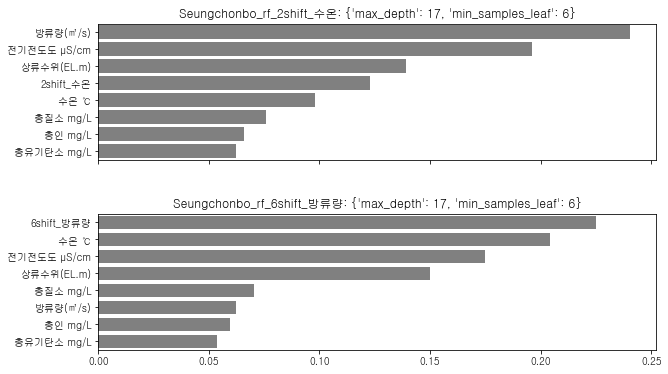

In [29]:
feature_importance_barplot(best_model_dict, model_params_dict, test_score_dict, train_features_dict)

## 모델 훈련 - Gradient Boosting

**회귀 모델 지정**

In [30]:
gb_reg = GradientBoostingRegressor(random_state=42)

**그리드 탐색 대상 하이퍼파라미터 지정**

In [31]:

parameters = {'max_depth':[10], 'learning_rate':[0.2]}
# parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

**shift 대상 특성**

shift 할 특성과 shift 크기의 쌍으로 이루어진 사전 자료형을 사용해서
지정된 특성에 대해 차례대로 특성 추가와 훈련을 처리하도록 한다.

In [32]:
# shift 대상과 크기 목록 사전
shift_objects = {'수온 ℃': 2, '방류량(㎥/s)':6}

**특성 중요도 확인**

지정된 shift 특성과 크기 각각에 대해 그리드 탐색을 시행한 후에 결과를 확인한다.

In [33]:
best_models = gridsearch(gb_reg, parameters, shift_objects)

=== Current model: Seungchonbo_gb_2shift_수온 ===
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ...learning_rate=0.2, max_depth=10;, score=0.925 total time=   9.3s
[CV 2/3] END ...learning_rate=0.2, max_depth=10;, score=0.926 total time=   9.2s
[CV 3/3] END ...learning_rate=0.2, max_depth=10;, score=0.924 total time=   9.2s
=== Current model: Seungchonbo_gb_6shift_방류량 ===
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ...learning_rate=0.2, max_depth=10;, score=0.926 total time=   9.8s
[CV 2/3] END ...learning_rate=0.2, max_depth=10;, score=0.928 total time=   9.9s
[CV 3/3] END ...learning_rate=0.2, max_depth=10;, score=0.927 total time=  10.0s


각각의 경우에 대한 특성 중요도를 막대그래프로 그려본다.

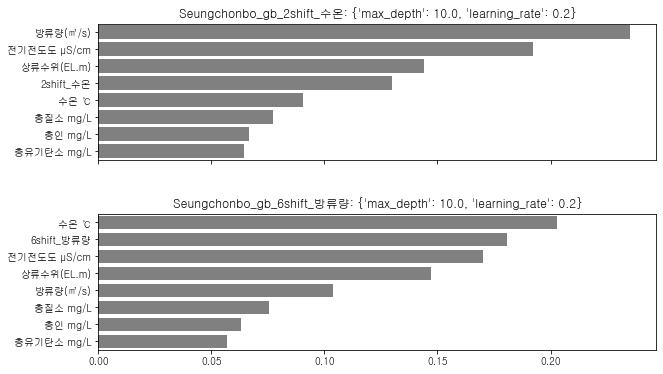

In [34]:
feature_importance_barplot(*best_models)